In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import datetime
from google.colab import drive
import pathlib

2.4.1


In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train_dense), (x_test, y_test_dense) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# swap training and testing set because test set is much smaller and easier to interpolate
x_train, x_test = x_test, x_train
y_train_dense, y_test_dense = y_test_dense, y_train_dense

# truncate the test set since it used to be the significatly larger training set
x_test, y_test_dense = x_test[:2000,:], y_test_dense[:2000]

# flatten inputs and convert label to one-hot
x_train = tf.reshape(x_train, (x_train.shape[0], -1))
x_test = tf.reshape(x_test, (x_test.shape[0], -1))
y_train, y_test = tf.one_hot(y_train_dense, 10), tf.one_hot(y_test_dense, 10)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(10000, 784) (2000, 784)
(10000, 10) (2000, 10)


In [3]:
# A plotting function you can reuse
def plot(history, title_prefix):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title(title_prefix+' Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

In [4]:
# stop training when fully interpolated (wrt classification as opposed to zero loss)
# https://arxiv.org/pdf/1812.11118.pdf trains for 6000 epochs per model, stopping early when interpolation is achieved
class CustomCallback_epoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      if logs["categorical_accuracy"]==1:
        self.model.stop_training = True
        print('STOPPING EARLY AFTER INTERPOLATING AT EPOCH %d' %epoch)
    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training\n", logs.items())

In [53]:
drive.mount("/content/drive")
# mount drive and load paths
logpath = pathlib.Path("/content/drive/My Drive/MDL_logs")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


50 RFF FEATURES
tf.Tensor(
[[171   0   3   0   3   3   1   0  10   0]
 [  0 210   2   1   0   1   1   2   3   0]
 [  4  13 139   3   7   2   1   8   9  12]
 [  1   2  11 135   1  15   3   4  15   4]
 [  2   4   6   0 178   3   4   0   3  14]
 [  2   6   7  16   3 113  11   1  17   4]
 [  1   4   3   2   6   4 172   1   6   1]
 [  6   4   3   1   9   5   3 176   3  14]
 [  1  12   7   6   2   8   1   4 126   5]
 [  4   2   0   4  18   2   0  24   4 152]], shape=(10, 10), dtype=int32)
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_fourier_features_77 ( (None, 50)                39251     
_________________________________________________________________
dense_77 (Dense)             (None, 10)                510       
Total params: 39,761
Trainable params: 510
Non-trainable params: 39,251
_________________________________________________________________
max training accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tf.Tensor(
[[188   1   0   0   0   2   0   0   0   0]
 [  0 214   0   0   1   0   1   1   3   0]
 [  1   3 184   1   2   1   1   3   1   1]
 [  1   1   5 167   0   8   1   0   1   7]
 [  0   2   3   0 199   0   2   2   0   6]
 [  0   1   1   4   0 164   5   0   2   3]
 [  2   1   0   0   3   2 191   0   1   0]
 [  3   1   0   1   5   2   0 203   1   8]
 [  0   1   1   1   0   4   1   1 162   1]
 [  2   0   0   2   2   0   0   3   0 201]], shape=(10, 10), dtype=int32)
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_fourier_features_96 ( (None, 17000)             13345001  
_________________________________________________________________
dense_96 (Dense)             (None, 10)                170010    
Total params: 13,515,011
Trainable params: 170,010
Non-trainable params: 13,345,001
_________________________________________________________________
max training accuracy 1.0

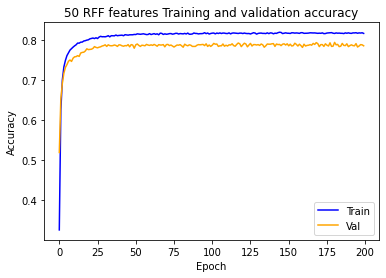

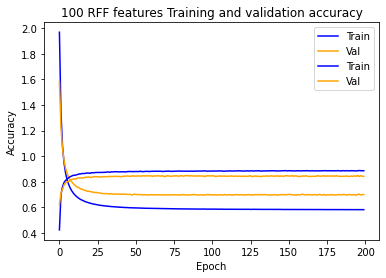

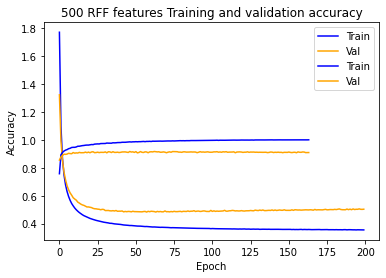

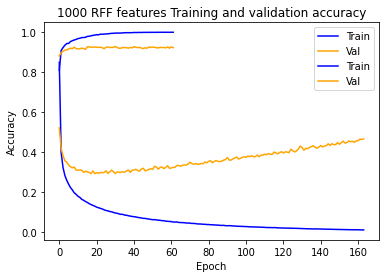

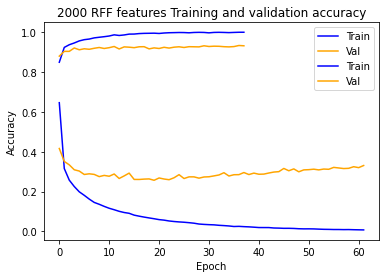

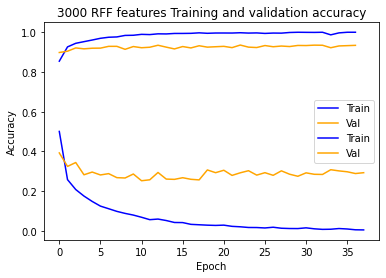

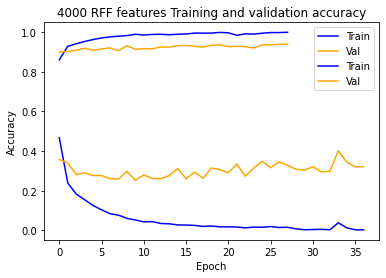

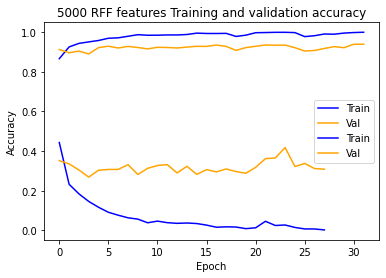

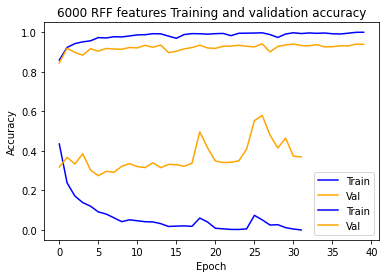

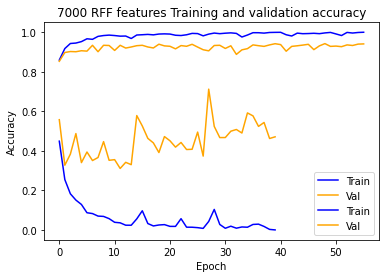

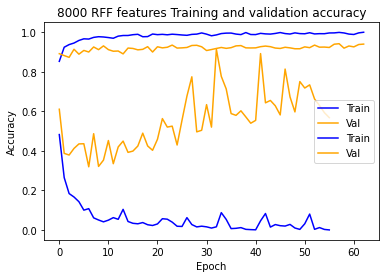

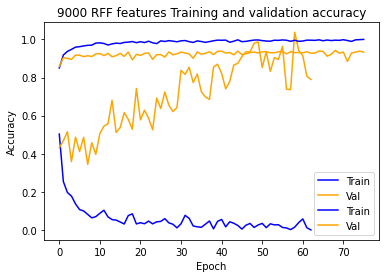

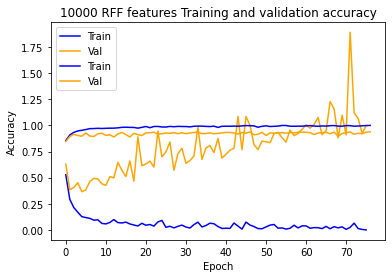

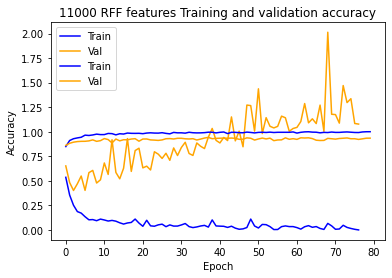

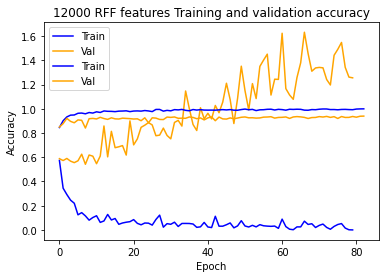

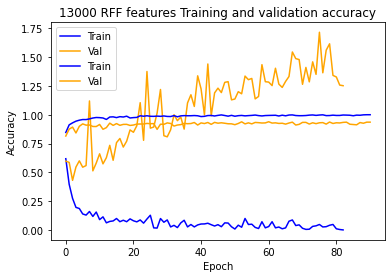

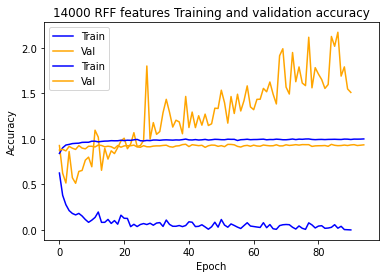

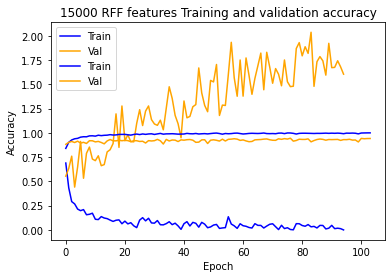

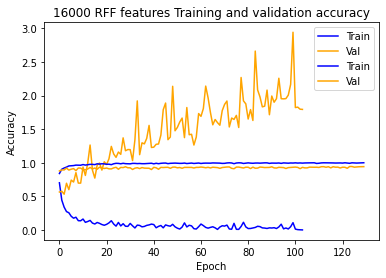

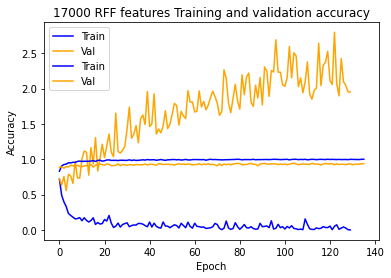

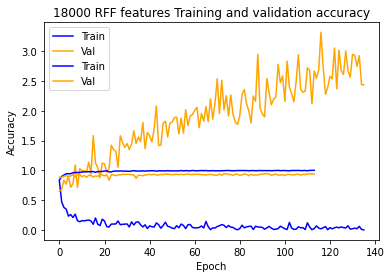

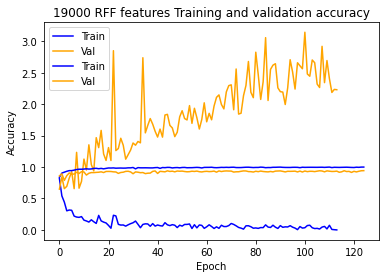

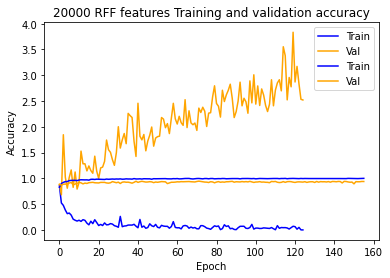

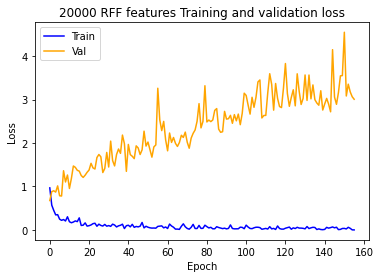

In [82]:
# %%capture cap --no-stderr
# start_time = str(datetime.datetime.now())
# filename = pathlib.Path.joinpath(logpath,'output_%s.txt' %start_time)
    
for N in [50, 100, 500] + list(map(lambda x:1000*x,range(1,21))):
  print('='*80)
  print('%d RFF FEATURES' %N) 
  print('='*80)
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/RandomFourierFeatures
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(784,)),
    RandomFourierFeatures(
        output_dim=N,
        scale=10.,
        kernel_initializer='gaussian'),
    tf.keras.layers.Dense(units=10, activation='softmax'),
  ])
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
  )

  history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), callbacks=[CustomCallback_epoch()], verbose=0)

  plot(history, '%d RFF features' %N)
  print(tf.math.confusion_matrix(y_test_dense, tf.argmax(model.predict(x_test), axis=1)))
  model.summary()
  print('max training accuracy', max(history.history['categorical_accuracy']))
  print('min training loss', min(history.history['loss']))
  print('max validation accuracy', max(history.history['val_categorical_accuracy']))
  print('min validation loss', min(history.history['val_loss']))
  
# # log outputs in file
# with open(filename, 'w') as f:
#   f.write(cap.stdout)

In [67]:
!ls /content/drive/My\ Drive/MDL_logs

'output_2021-03-24 02:05:04.018787.txt'
'output_2021-03-24 02:05:41.375281.txt'


2 RFF FEATURES
tf.Tensor(
[[ 92  31  25  19   0   2   0  18   4   0]
 [  5 165  15   0   0   6   0  28   1   0]
 [ 48  40  29  47   0   6   0  22   5   1]
 [ 28  32  26  81   0   5   0  18   1   0]
 [ 21 130  17  13   0   6   0  25   2   0]
 [ 11  90  14  37   0   9   0  19   0   0]
 [  9 140   8   9   0   6   0  26   1   1]
 [ 17 128  31  13   0   8   0  25   1   1]
 [ 40  58  18  20   0   9   0  27   0   0]
 [ 19 138  11   7   0   4   0  30   0   1]], shape=(10, 10), dtype=int32)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_fourier_features_21 ( (None, 2)                 1571      
_________________________________________________________________
dense_21 (Dense)             (None, 10)                30        
Total params: 1,601
Trainable params: 30
Non-trainable params: 1,571
_________________________________________________________________
max training accuracy 0.2

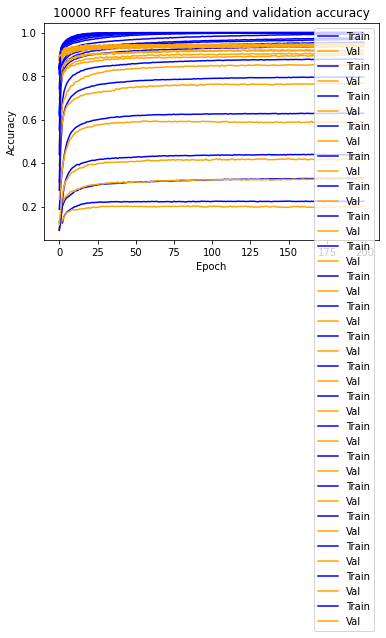

In [7]:
# %%capture cap --no-stderr
# start_time = str(datetime.datetime.now())
# filename = pathlib.Path.joinpath(logpath,'output_%s.txt' %start_time)
    
for N in [2, 5, 10, 25, 50, 100, 200, 300, 400, 500] + list(map(lambda x:1000*x,range(1,11))):
  print('='*80)
  print('%d RFF FEATURES' %N) 
  print('='*80)
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/RandomFourierFeatures
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(784,)),
    RandomFourierFeatures(
        output_dim=N,
        scale=10.,
        kernel_initializer='gaussian'),
    tf.keras.layers.Dense(units=10, activation='softmax'),
  ])
  model.compile(
      optimizer='sgd',
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
  )

  history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), verbose=0)

  plot(history, '%d RFF features' %N)
  print(tf.math.confusion_matrix(y_test_dense, tf.argmax(model.predict(x_test), axis=1)))
  model.summary()
  print('max training accuracy', max(history.history['categorical_accuracy']))
  print('min training loss', min(history.history['loss']))
  print('max validation accuracy', max(history.history['val_categorical_accuracy']))
  print('min validation loss', min(history.history['val_loss']))
  
# # log outputs in file
# with open(filename, 'w') as f:
#   f.write(cap.stdout)

2 RFF FEATURES
tf.Tensor(
[[ 72   9  28   0   0   0   0  12   0  70]
 [ 26 114  27   0   0   0   2   9   0  42]
 [ 15  38  92   0   0   0   1  24   0  28]
 [ 56  30  52   0   0   0   0  18   0  35]
 [ 47  47  44   0   0   0   0  24   0  52]
 [ 52  43  27   0   0   0   3  14   0  41]
 [ 62  27  39   0   0   0   2  11   0  59]
 [ 45  30  36   0   0   0   1  31   0  81]
 [ 26  25  60   0   0   0   0  14   0  47]
 [ 34  23  30   0   0   0   1  28   0  94]], shape=(10, 10), dtype=int32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_fourier_features_1 (R (None, 2)                 1571      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                30        
Total params: 1,601
Trainable params: 30
Non-trainable params: 1,571
_________________________________________________________________
max training accuracy 0.20

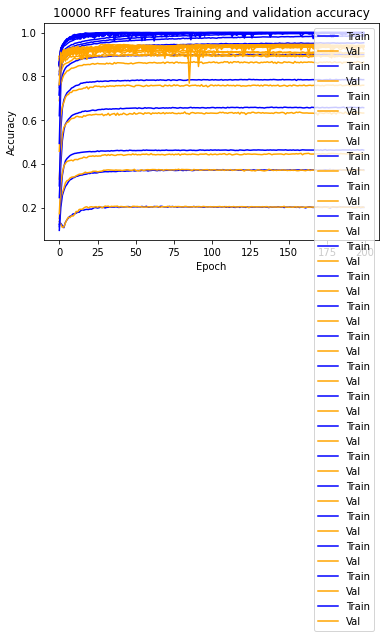

In [6]:
# %%capture cap --no-stderr
# start_time = str(datetime.datetime.now())
# filename = pathlib.Path.joinpath(logpath,'output_%s.txt' %start_time)
    
for N in [2, 5, 10, 25, 50, 100, 200, 300, 400, 500] + list(map(lambda x:1000*x,range(1,11))):
  print('='*80)
  print('%d RFF FEATURES' %N) 
  print('='*80)
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/RandomFourierFeatures
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(784,)),
    RandomFourierFeatures(
        output_dim=N,
        scale=10.,
        kernel_initializer='gaussian'),
    tf.keras.layers.Dense(units=10, activation='softmax'),
  ])
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
  )

  history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), verbose=0)

  plot(history, '%d RFF features' %N)
  print(tf.math.confusion_matrix(y_test_dense, tf.argmax(model.predict(x_test), axis=1)))
  model.summary()
  print('max training accuracy', max(history.history['categorical_accuracy']))
  print('min training loss', min(history.history['loss']))
  print('max validation accuracy', max(history.history['val_categorical_accuracy']))
  print('min validation loss', min(history.history['val_loss']))
  
# # log outputs in file
# with open(filename, 'w') as f:
#   f.write(cap.stdout)